In [2]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

# Percentage of used scripts in time

Observe how the used scripts changed over time. All scripts using witnesses are in the `SegWit` category.

CPU times: user 10min 30s, sys: 16.2 s, total: 10min 46s
Wall time: 4.2 s


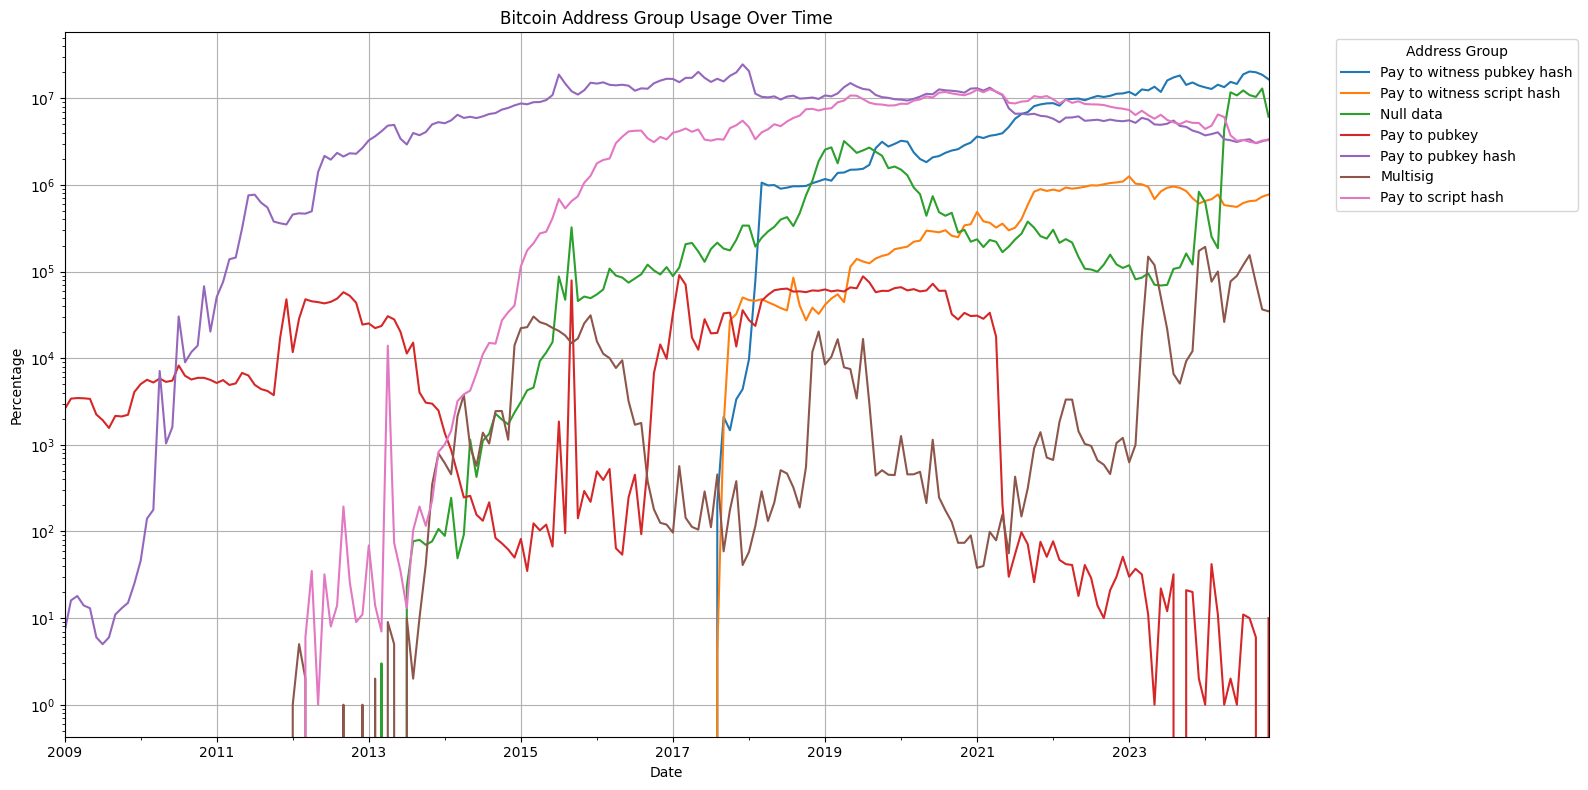

Pay to witness pubkey hash    5.998778e+08
Pay to witness script hash    4.102494e+07
Null data                     1.347893e+08
Pay to pubkey                 3.579348e+06
Pay to pubkey hash            1.366634e+09
Multisig                      2.058709e+06
Pay to script hash            7.422646e+08
dtype: float64


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

%time data = chain.get_count_of_address_types_for_each_day(0, len(chain))

df = pd.DataFrame.from_dict(data, orient='index')
df = df.fillna(0).T  # Transpose to make days the rows
df.index = pd.to_datetime(df.index.map(lambda x: datetime.utcfromtimestamp(x * 86400)))

group_mapping = {
    #blocksci.address_type.witness_pubkeyhash: "segwit",
    blocksci.address_type.witness_unknown: "segwit",
    blocksci.address_type.nonstandard: "", 
    #blocksci.address_type.witness_scripthash: "segwit",
}

# segwit_total = df[group_mapping.keys()].sum(axis=1)  # Sum up all segwit categories
# df["SegWit"] = segwit_total 

df = df.drop(columns=group_mapping.keys())

df = df.resample('M').sum()

# df['total'] = df.sum(axis=1)

# percentages = df.div(df['total'], axis=0) * 100
# percentages = percentages.drop(columns=['total'])


plt.figure(figsize=(16, 8))
df.plot(kind='line', ax=plt.gca())

plt.legend(title='Address Group', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Bitcoin Address Group Usage Over Time')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.yscale('log')
plt.grid()

plt.tight_layout()

# plt.savefig('/mnt/blocksci/address_group_usage_percent.png')
plt.show()

print(df.sum())

# CoinJoins


In [5]:
last_october_block = get_block_height_for_date('2024-10-31')

%time ww2_coinjoins = chain.filter_coinjoin_txes(0, last_october_block, "wasabi2")
%time ww1_coinjoins = chain.filter_coinjoin_txes(0, last_october_block, "wasabi1")
%time sw_coinjoins = chain.filter_coinjoin_txes(0, last_october_block, "whirlpool")
print(len(ww2_coinjoins), len(ww1_coinjoins), len(sw_coinjoins))

CPU times: user 1min 25s, sys: 199 ms, total: 1min 26s
Wall time: 977 ms
CPU times: user 2min 39s, sys: 240 ms, total: 2min 39s
Wall time: 2.7 s
CPU times: user 1min 30s, sys: 649 ms, total: 1min 30s
Wall time: 1.9 s
40015 34783 541107


## Number of coinjoins in the wild

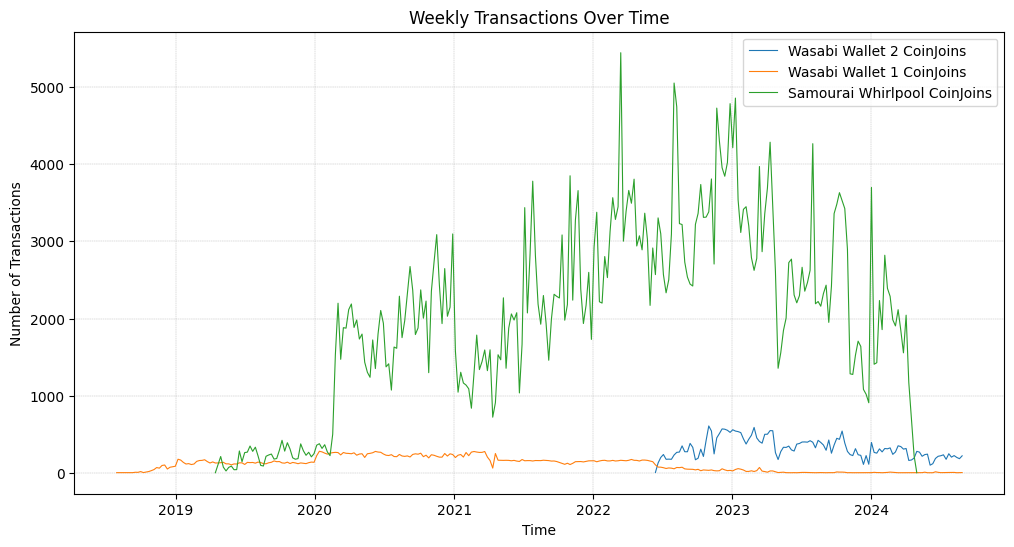

In [4]:
def process_transactions(transactions, label):
    transactions = list(map(lambda tx: {"block_time": tx.block_time}, transactions))
    df = pd.DataFrame(transactions)
    df['block_time'] = pd.to_datetime(df['block_time'])
    df['week'] = df['block_time'].dt.to_period('W').dt.to_timestamp()  # Get the timestamp for the start of the week
    weekly_counts = df.groupby('week').size()
    return weekly_counts, label

weekly_counts_ww2, label_1 = process_transactions(ww2_coinjoins, "Wasabi Wallet 2 CoinJoins")
weekly_counts_ww1, label_2 = process_transactions(ww1_coinjoins, "Wasabi Wallet 1 CoinJoins")
weekly_counts_sw, label_3 = process_transactions(sw_coinjoins, "Samourai Whirlpool CoinJoins")

plt.figure(figsize=(12, 6))

plt.plot(weekly_counts_ww2.index, weekly_counts_ww2.values, label=label_1, linewidth=0.8)
plt.plot(weekly_counts_ww1.index, weekly_counts_ww1.values, label=label_2, linewidth=0.8)
plt.plot(weekly_counts_sw.index, weekly_counts_sw.values, label=label_3, linewidth=0.8)

plt.title("Weekly Transactions Over Time")
plt.xlabel("Time")
plt.ylabel("Number of Transactions")
plt.legend()

plt.grid(True, linestyle='--', linewidth=0.3)
plt.savefig("/mnt/blocksci/weekly_cjs_over_time.png")

plt.show()


## Liquidity

In [5]:
tx: blocksci.Tx
i: blocksci.Input
from collections import defaultdict
from datetime import datetime, timedelta

def process_input_liquidity(cjs, label):
    input_liquitidy_per_date = {}
    s = set(cjs)
    
    for tx in cjs:
        tx_date = tx.block_time.date()
        if tx_date not in input_liquitidy_per_date:
            input_liquitidy_per_date[tx_date] = 0
    
        for i in tx.inputs:
            if i.spent_tx in s:
                continue
    
            input_liquitidy_per_date[tx_date] += i.value

    sorted_liquidity = {k: v // 100000000 for k, v in sorted(input_liquitidy_per_date.items(), key=lambda t: t[0])}
    

    return sorted_liquidity, label

liq1, lab1 = process_input_liquidity(ww2_coinjoins, "Wasabi2 Input Liquidity")
liq2, lab2 = process_input_liquidity(ww1_coinjoins, "Wasabi1 Input Liquidity")
liq3, lab3 = process_input_liquidity(sw_coinjoins, "Whirlpool Input Liquidity")

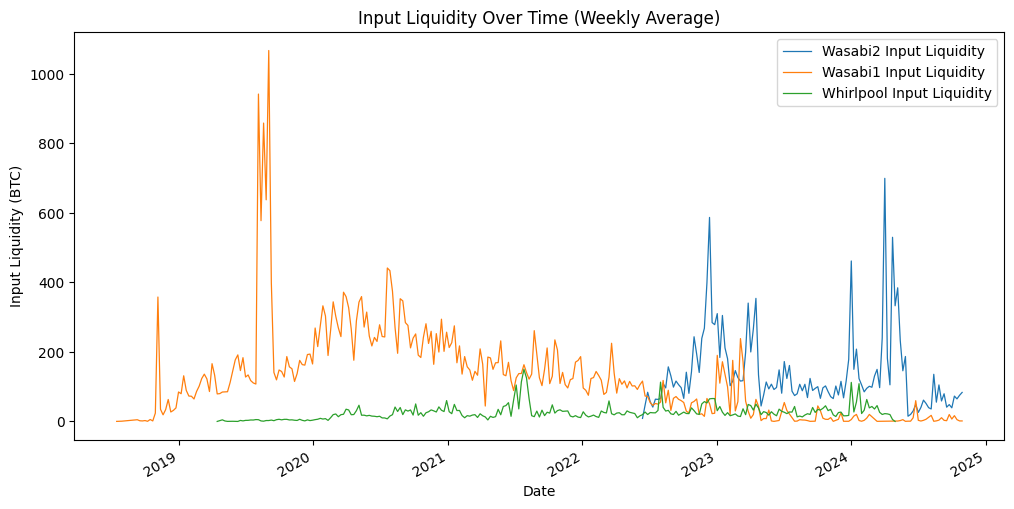

In [6]:
def group_by_week(data):
    weekly_data = defaultdict(int)
    for date, count in data.items():
        nd = datetime.combine(date, datetime.min.time())
        week_start = nd - timedelta(days=nd.weekday())
        weekly_data[week_start] += count

    for k in weekly_data:
        weekly_data[k] /= 7
    return dict(sorted(weekly_data.items()))

weekly_data1 = group_by_week(liq1)
weekly_data2 = group_by_week(liq2)
weekly_data3 = group_by_week(liq3)


# Prepare dates and values for plotting
dates1, values1 = zip(*weekly_data1.items())
dates2, values2 = zip(*weekly_data2.items())
dates3, values3 = zip(*weekly_data3.items())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(dates1, values1, label=lab1, linewidth=0.9)
plt.plot(dates2, values2, label=lab2, linewidth=0.9)
plt.plot(dates3, values3, label=lab3, linewidth=0.9)

# Add labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Input Liquidity (BTC)")
plt.title("Input Liquidity Over Time (Weekly Average)")
plt.legend()

# Improve date formatting on the x-axis
plt.gcf().autofmt_xdate()

# Show the plot
plt.savefig("/mnt/blocksci/input_liquidity_weekly.png")
plt.show()



## Traverses

In [6]:
%time traverses = chain.find_traverses_between_coinjoins(0, get_block_height_for_date('2024-10-31'))

CPU times: user 31min 45s, sys: 4.38 s, total: 31min 50s
Wall time: 1min 59s


In [7]:
def cmp(cjt1, cjt2):
    return int(cjt1) < int(cjt2)

blocksci.CoinJoinType.__lt__ = cmp

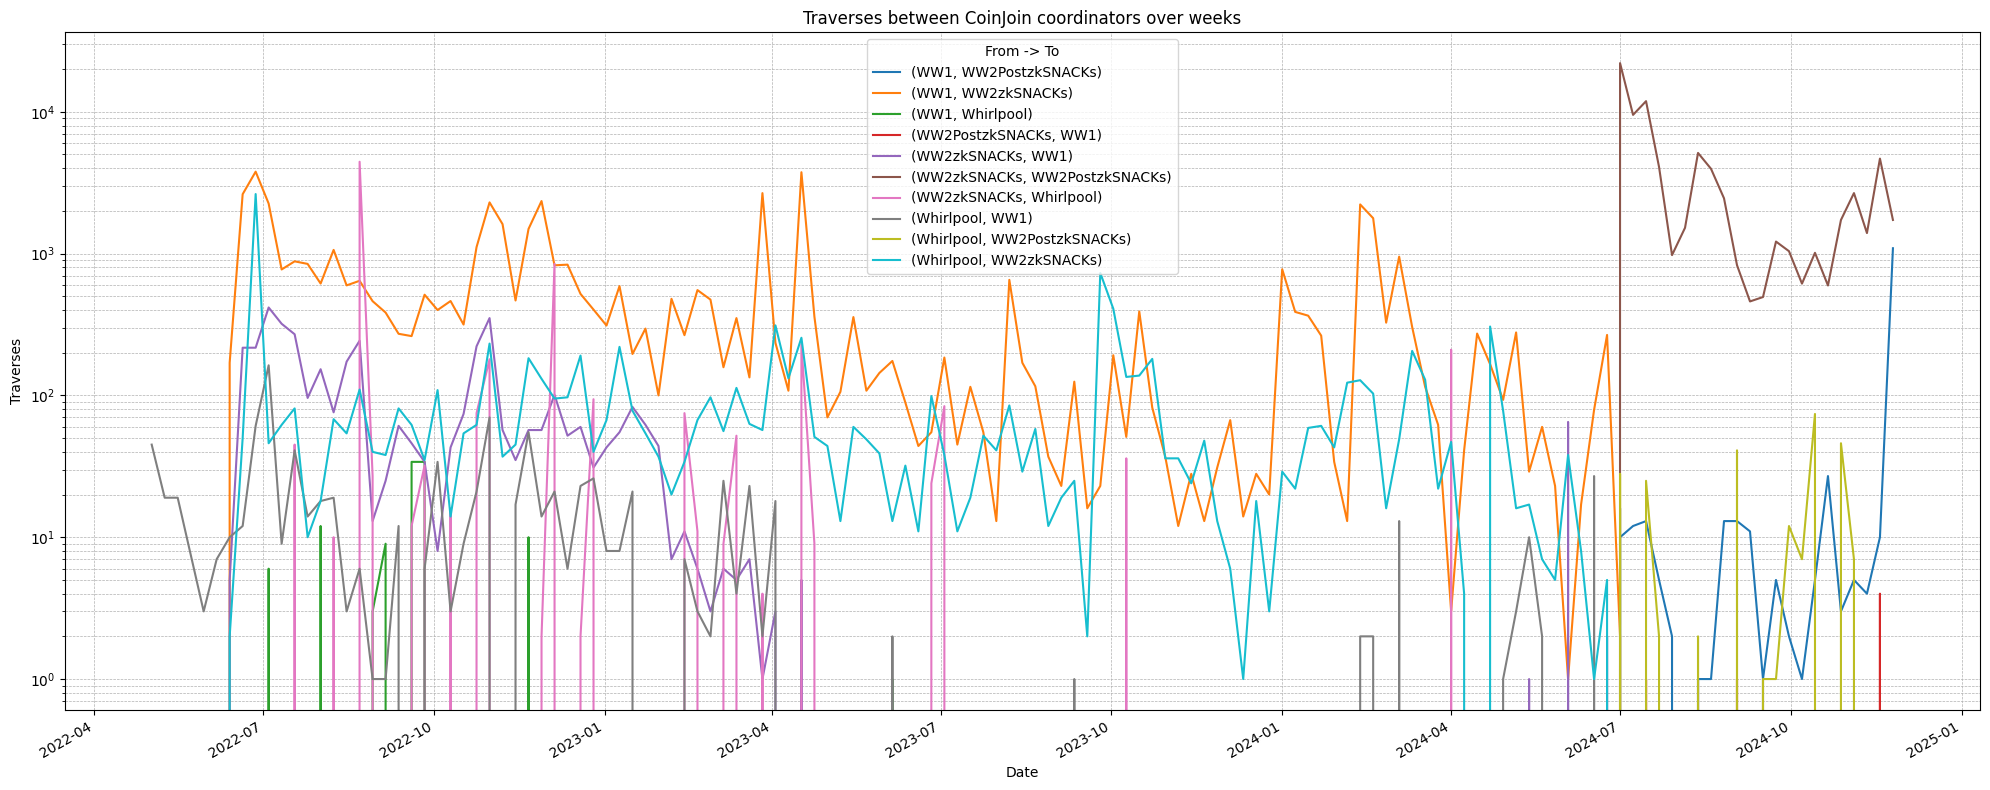

In [8]:
import datetime

# flatten and convert to enums
records = []
for dt, from_map in traverses.items():
    for from_cj, to_map in from_map.items():
        for to_cj, count in to_map.items():
            time = chain[dt].time
            # non-relevant values before this date
            if time < datetime.datetime(2022, 5, 1):
                continue
            records.append({"datetime": time, "from_cj": str(blocksci.CoinJoinType(from_cj)).split('.')[1], "to_cj": str(blocksci.CoinJoinType(to_cj)).split('.')[1], "count": count})

df = pd.DataFrame(records)
df['datetime'] = pd.to_datetime(df['datetime'])

# aggregate over weeks
df['week'] = df['datetime'].dt.to_period('W').apply(lambda x: x.start_time)

# get all unique values over weeks
unique_weeks = df['week'].unique()
unique_from_cj = df['from_cj'].unique()
unique_to_cj = df['to_cj'].unique()

# create an index in the DF for the cartesian product of all unique from->to values over weeks
full_index = pd.MultiIndex.from_product(
    [unique_weeks, unique_from_cj, unique_to_cj],
    names=["week", "from_cj", "to_cj"]
)

# Reindex the original data to align with the full set of combinations
df['week'] = df['week'].dt.normalize()
df_full = df.groupby(['week', 'from_cj', 'to_cj'])['count'].sum().reset_index()
df_full = df_full.set_index(["week", "from_cj", "to_cj"]).reindex(full_index, fill_value=0).reset_index()

# Pivot the DF over weeks
pivot_df = df_full.pivot_table(
    index="week",
    columns=["from_cj", "to_cj"],
    values="count",
    fill_value=0
)


pivot_df = pivot_df.drop(columns=pivot_df.columns[(pivot_df == 0).all()])

pivot_df.plot(figsize=(20, 8), logy=True)
plt.title("Traverses between CoinJoin coordinators over weeks")
plt.xlabel("Date")
plt.ylabel("Traverses")
plt.legend(title="From -> To")
plt.tight_layout()
plt.grid(True, which="both", ls="--", linewidth=0.5)
# plt.savefig("/mnt/blocksci/traverses.png")


plt.show()


## Anonymity degradation

### calculation

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from math import log2, factorial


def plot_anonymity_degradation(original_data, after_day_data, after_week_data, after_month_data, after_year, after_all, tag):
    # the log2(factorial(tx.output_count)) is used to normalize over the output count to compute sort of "percentage"
    # of the available "entropy"
    df_original = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in original_data.items()],
        columns=["block_time", "original_anonymity_score"],
    )

    df_after_day = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_day_data.items()],
        columns=["block_time", "anonymity_set_after_day"],
    )
    
    df_after_week = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_week_data.items()],
        columns=["block_time", "anonymity_set_after_week"],
    )
    df_after_month = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_month_data.items()],
        columns=["block_time", "anonymity_set_after_month"],
    )

    df_after_year = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_year.items()],
        columns=["block_time", "anonymity_set_after_year"],
    )

    df_after_all = pd.DataFrame(
        [(transaction.block_time, count / log2(factorial(transaction.output_count))) for transaction, count in after_all.items()],
        columns=["block_time", "anonymity_set_after_all"],
    )
    
    # Ensure block_time is a datetime object
    df_original["block_time"] = pd.to_datetime(df_original["block_time"])
    df_after_day["block_time"] = pd.to_datetime(df_after_day["block_time"])
    df_after_week["block_time"] = pd.to_datetime(df_after_week["block_time"])
    df_after_month["block_time"] = pd.to_datetime(df_after_month["block_time"])
    df_after_year["block_time"] = pd.to_datetime(df_after_year["block_time"])
    df_after_all["block_time"] = pd.to_datetime(df_after_all["block_time"])
    
    # Group by week start for both datasets
    df_original["week_start"] = df_original["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_day["week_start"] = df_after_day["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_week["week_start"] = df_after_week["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_month["week_start"] = df_after_month["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_year["week_start"] = df_after_year["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    df_after_all["week_start"] = df_after_all["block_time"].dt.to_period("W").apply(lambda r: r.start_time)
    
    # Aggregate by week and calculate the mean for both
    weekly_original = df_original.groupby("week_start")["original_anonymity_score"].mean().reset_index()
    weekly_after_day = df_after_day.groupby("week_start")["anonymity_set_after_day"].mean().reset_index()
    weekly_after_week = df_after_week.groupby("week_start")["anonymity_set_after_week"].mean().reset_index()
    weekly_after_month = df_after_month.groupby("week_start")["anonymity_set_after_month"].mean().reset_index()
    weekly_after_year = df_after_year.groupby("week_start")["anonymity_set_after_year"].mean().reset_index()
    weekly_after_all = df_after_all.groupby("week_start")["anonymity_set_after_all"].mean().reset_index()
    
    # Merge both datasets on the week_start
    weekly_data = pd.merge(weekly_original, weekly_after_week, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_day, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_month, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_year, on="week_start", how="outer")
    weekly_data = pd.merge(weekly_data, weekly_after_all, on="week_start", how="outer")
    
    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(
        weekly_data["week_start"],
        weekly_data["original_anonymity_score"],
        label="Original computed anonymity value",
        linewidth=0.8,
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_day"],
        label="Computed anonymity value after 1 day",
        linewidth=0.8,
        linestyle='dotted'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_week"],
        label="Computed anonymity value after 7 days",
        linewidth=0.8,
        linestyle='dashed',
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_month"],
        label="Computed anonymity value after 31 days",
        linewidth=0.8,
        linestyle='dashdot'
    )
    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_year"],
        label="Computed anonymity value after 365 days",
        linewidth=0.8,
        linestyle='dotted'
    )

    plt.plot(
        weekly_data["week_start"],
        weekly_data["anonymity_set_after_all"],
        label="Computed anonymity value with no time limit",
        linewidth=1,
        linestyle='dashed'
    )
    
    plt.xlabel("Week")
    plt.ylabel("Computed anonymity value")
    plt.title(f"Computed anonymity values for {tag.split('_')[0].upper()} CoinJoins")
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"/mnt/blocksci/anonymity_degradation_{tag}.png")
    plt.show()


### results

CPU times: user 3min 7s, sys: 1.67 s, total: 3min 9s
Wall time: 3.79 s
CPU times: user 30min 4s, sys: 5 s, total: 30min 9s
Wall time: 17 s
CPU times: user 31min 10s, sys: 5.92 s, total: 31min 16s
Wall time: 19.3 s
CPU times: user 28min 21s, sys: 3.96 s, total: 28min 25s
Wall time: 15.1 s
CPU times: user 30min 18s, sys: 7.62 s, total: 30min 26s
Wall time: 16.1 s
CPU times: user 29min 54s, sys: 6.85 s, total: 30min 1s
Wall time: 17.6 s


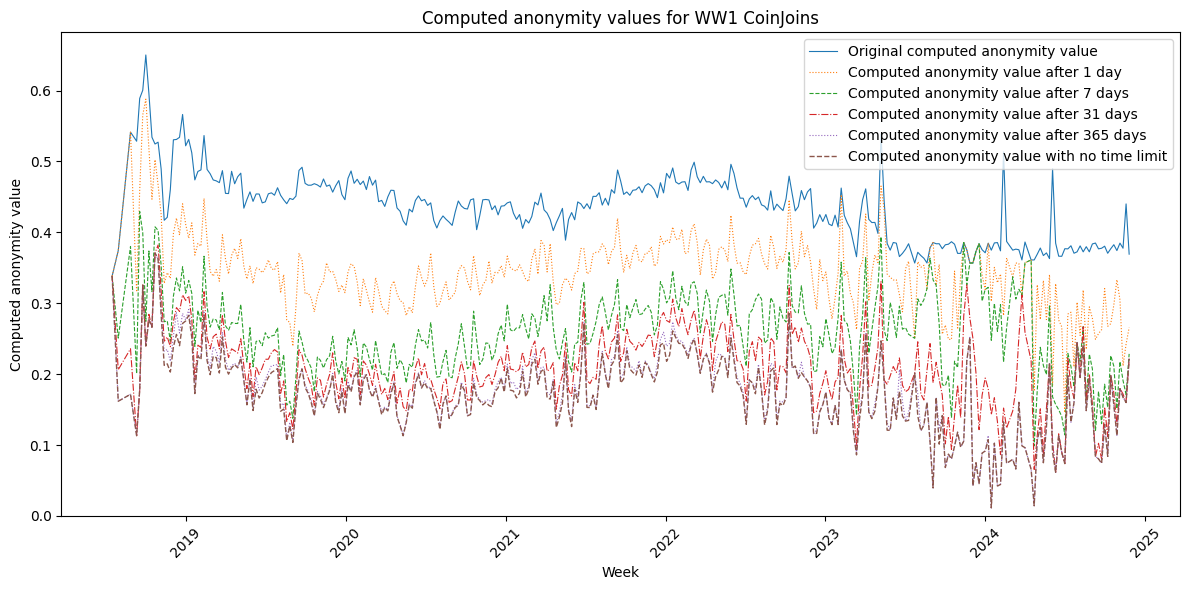

CPU times: user 1min 39s, sys: 858 ms, total: 1min 40s
Wall time: 1.42 s
CPU times: user 27min 4s, sys: 4.82 s, total: 27min 9s
Wall time: 12.6 s
CPU times: user 27min 53s, sys: 5.98 s, total: 27min 59s
Wall time: 13.8 s
CPU times: user 28min 55s, sys: 6.58 s, total: 29min 2s
Wall time: 14.2 s
CPU times: user 29min 53s, sys: 9.03 s, total: 30min 2s
Wall time: 15.2 s
CPU times: user 28min 31s, sys: 5.84 s, total: 28min 37s
Wall time: 13.7 s


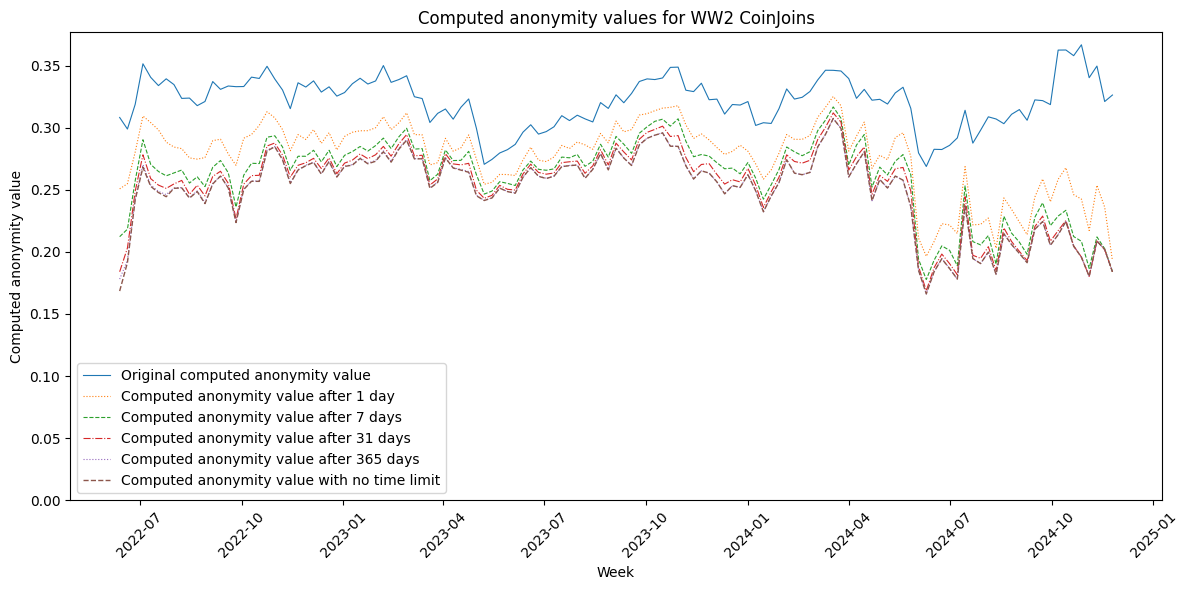

CPU times: user 1min 46s, sys: 2.75 s, total: 1min 49s
Wall time: 3.37 s
CPU times: user 36min 59s, sys: 10.7 s, total: 37min 10s
Wall time: 18.5 s
CPU times: user 41min 45s, sys: 11.8 s, total: 41min 57s
Wall time: 23.1 s
CPU times: user 42min 43s, sys: 12.8 s, total: 42min 56s
Wall time: 21.2 s
CPU times: user 45min 18s, sys: 7.88 s, total: 45min 25s
Wall time: 22.6 s
CPU times: user 46min 17s, sys: 10.7 s, total: 46min 27s
Wall time: 25.7 s


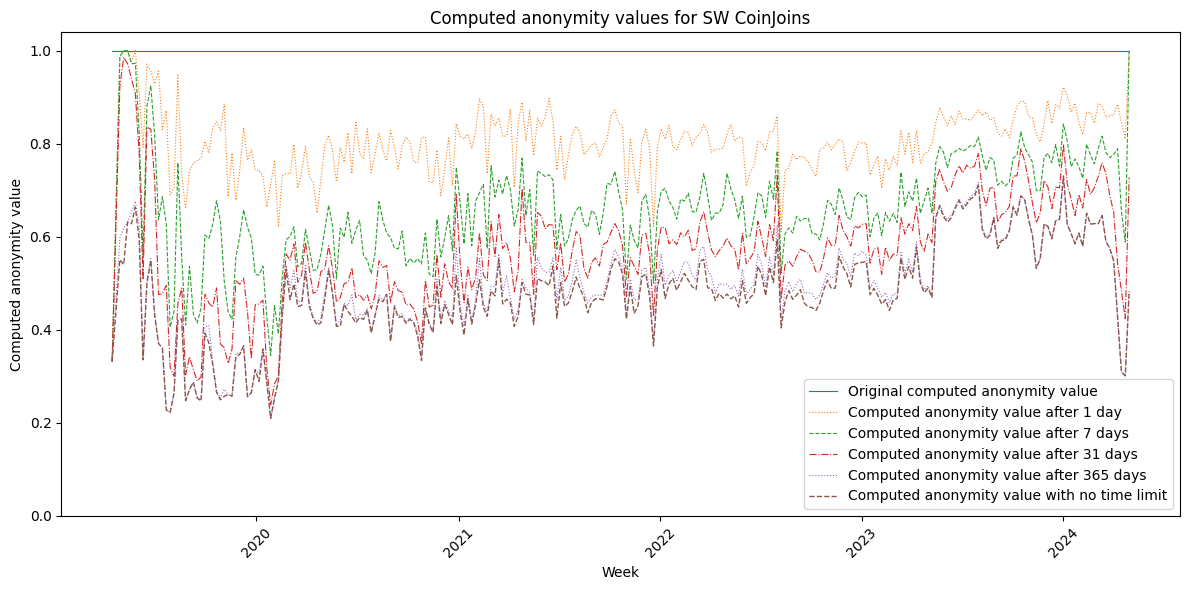

In [10]:
%time ww1_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi1")
%time ww1_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi1")
%time ww1_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi1")
%time ww1_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi1")
%time ww1_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi1")
%time ww1_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi1")

plot_anonymity_degradation(ww1_original_data, ww1_after_day_data, ww1_after_week_data, ww1_after_month_data, ww1_after_year_data, ww1_after_full_data, "ww1_multiple_txes")

%time ww2_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "wasabi2")
%time ww2_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "wasabi2")
%time ww2_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "wasabi2")
%time ww2_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "wasabi2")
%time ww2_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "wasabi2")
%time ww2_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "wasabi2")

plot_anonymity_degradation(ww2_original_data, ww2_after_day_data, ww2_after_week_data, ww2_after_month_data, ww2_after_year_data, ww2_after_full_data, "ww2_multiple_txes")


%time sw_original_data = chain.compute_anonymity_degradation(0, len(chain), 0, "whirlpool")
%time sw_after_day_data = chain.compute_anonymity_degradation(0, len(chain), 1, "whirlpool")
%time sw_after_week_data = chain.compute_anonymity_degradation(0, len(chain), 7, "whirlpool")
%time sw_after_month_data = chain.compute_anonymity_degradation(0, len(chain), 31, "whirlpool")
%time sw_after_year_data = chain.compute_anonymity_degradation(0, len(chain), 365, "whirlpool")
%time sw_after_full_data = chain.compute_anonymity_degradation(0, len(chain), 365*7, "whirlpool")

plot_anonymity_degradation(sw_original_data, sw_after_day_data, sw_after_week_data, sw_after_month_data, sw_after_year_data, sw_after_full_data, "sw_multiple_txes")